# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

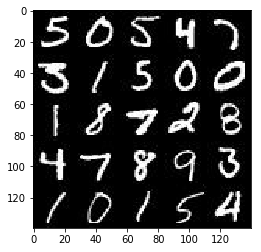

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

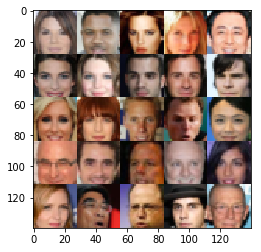

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', activation=tf.nn.relu)
        # 14x14x128

        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same', activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # 7x7x256

        #print(bn2.shape) #(?, 7, 7, 256)
        # Flatten it
        flat = tf.reshape(bn2, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        #print(x1.shape)# 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        #print(x2.shape)# 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)# 28x28xN now
        
        out = tf.tanh(logits)
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    
    labels_real = tf.ones_like(d_model_real)* (1 - smooth)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every=25
    show_every=100
  
    out_channel_dim = data_shape[3]
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)    
    #out_channel_dim = 1 if data_image_mode == "L" then 3
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
            
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 2.0555
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 2.7632... Generator Loss: 0.1489
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.8460


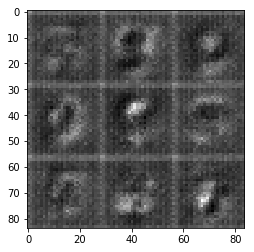

Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 2.2034
Epoch 1/2... Discriminator Loss: 0.7268... Generator Loss: 1.3944
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.9981
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 1.2562


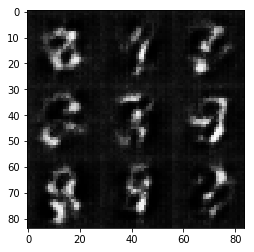

Epoch 1/2... Discriminator Loss: 0.7441... Generator Loss: 1.7795
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.5035
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.8882


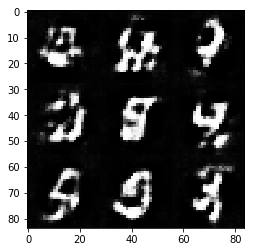

Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.7219
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.7317
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 2.1329
Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.9730


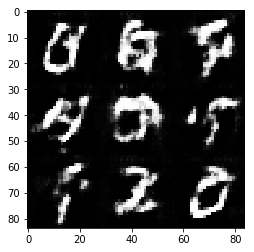

Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.8385
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.6122


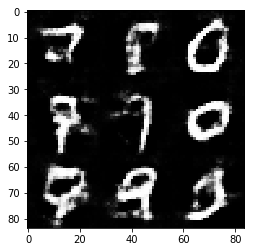

Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.8753
Epoch 1/2... Discriminator Loss: 0.8960... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.8168


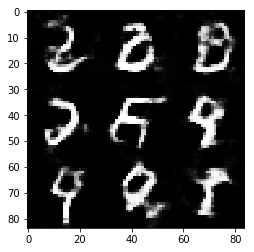

Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.8466
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.4994
Epoch 1/2... Discriminator Loss: 0.9323... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 0.8919


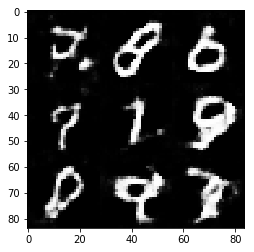

Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.1501
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.8071... Generator Loss: 1.5748
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 0.8106


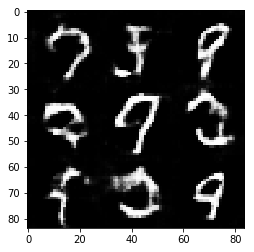

Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.5551
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 1.1840
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.8539


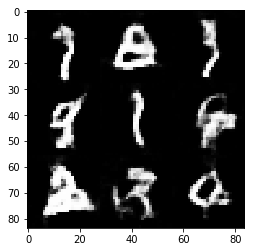

Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.2138
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 1.5033
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.2786
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.2003


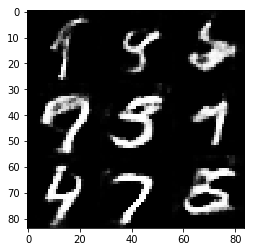

Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.3927
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.7491
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.6013


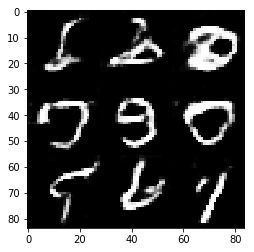

Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.4289
Epoch 2/2... Discriminator Loss: 0.8439... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.5282
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.8668


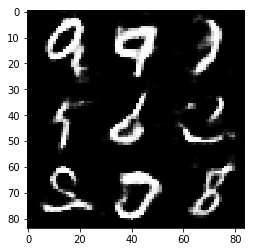

Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.7745
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.8832
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.3525


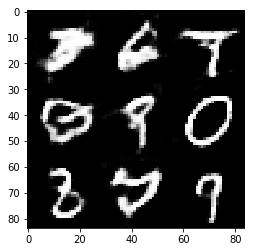

Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.3509
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 0.7583


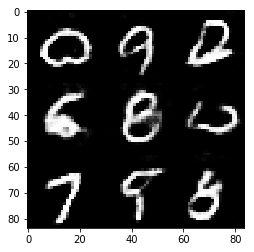

Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.9687
Epoch 2/2... Discriminator Loss: 0.8737... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.2600
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.4784


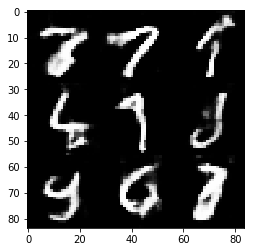

Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 1.6398
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 1.8584


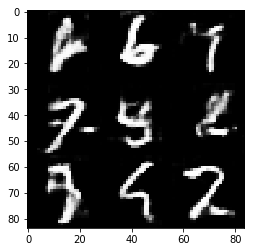

Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.3316
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.0992
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 2.4114


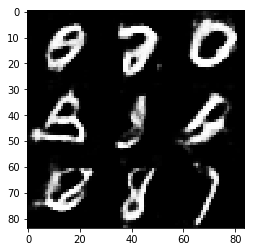

Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.5319
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.3287
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.4872
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.8564


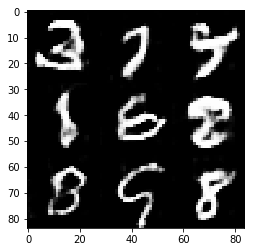

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 2.1809
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 1.5604


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.7268
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 3.4313
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 4.4864


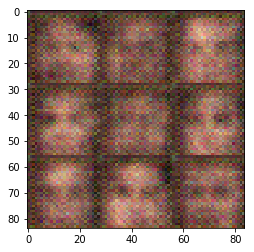

Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.8231
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.8274
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7847


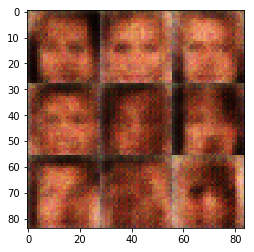

Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.0570
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6630


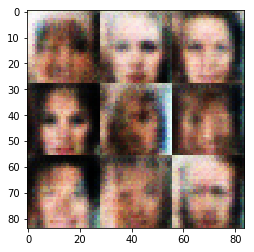

Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.4873


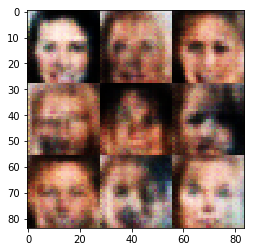

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.4979
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.8737


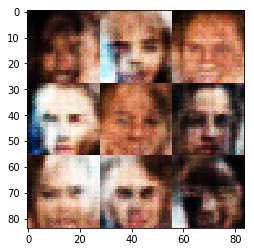

Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 2.2415


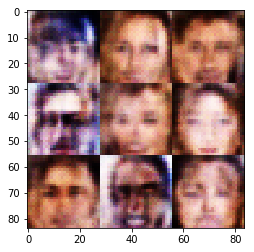

Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.6047
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 3.4533


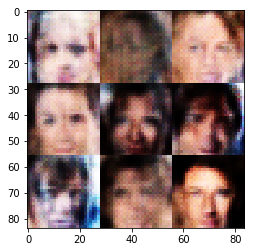

Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 4.0656
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 3.7020


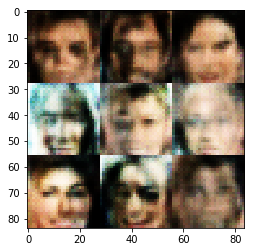

Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 2.4952
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 2.6155
Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 2.5245


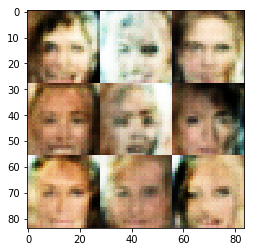

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 3.6856
Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 4.6081
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 3.2810


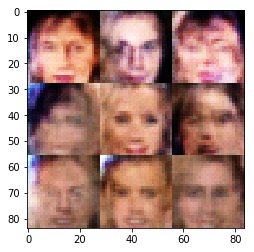

Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 4.6881
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 4.0653
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 4.0920


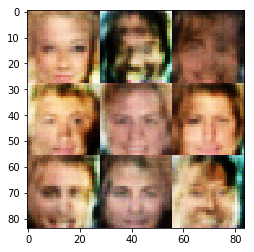

Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 4.1727
Epoch 1/1... Discriminator Loss: 0.4663... Generator Loss: 2.8742
Epoch 1/1... Discriminator Loss: 0.6556... Generator Loss: 1.7494
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 5.0088


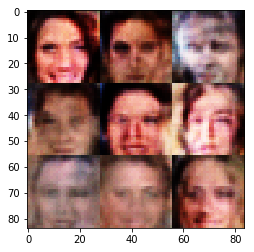

Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.6445
Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.8014
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.1434


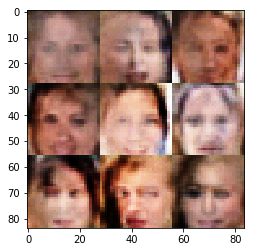

Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.2320
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 2.4177
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 3.2250
Epoch 1/1... Discriminator Loss: 0.4989... Generator Loss: 2.1537


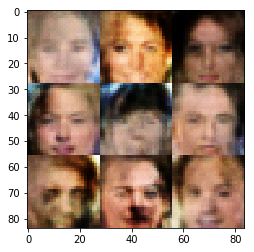

Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 4.7488
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.8923


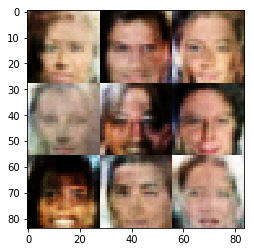

Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.6073
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 2.5987
Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 3.8707


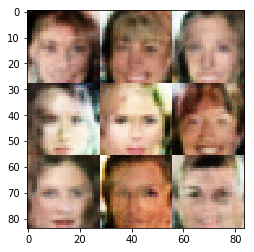

Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 4.0358
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.0711


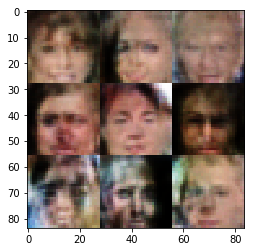

Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.6487
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.3881
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.4981


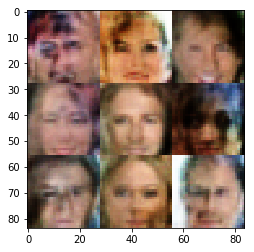

Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.2855
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.8779
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 2.4919


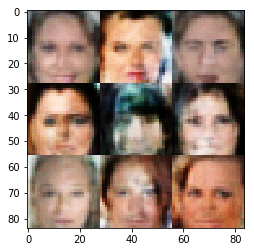

Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.3481
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 4.5742
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.1103
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.0230


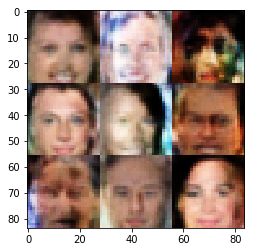

Epoch 1/1... Discriminator Loss: 0.3843... Generator Loss: 5.2345
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 4.0900
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 2.8076
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 4.4583


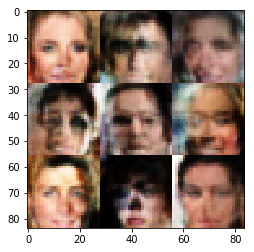

Epoch 1/1... Discriminator Loss: 0.5292... Generator Loss: 2.1176
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 8.2016
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.4610


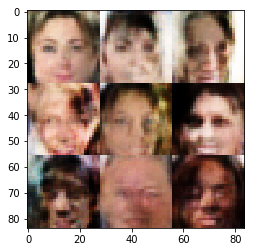

Epoch 1/1... Discriminator Loss: 0.4573... Generator Loss: 3.7430
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 2.0480
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.5302
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 5.6568


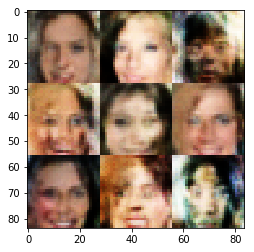

Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.7838
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.8282


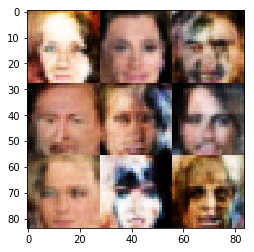

Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.3018
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 3.9287
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6803


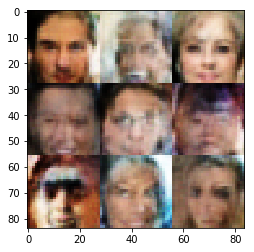

Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 2.3841
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 3.5153


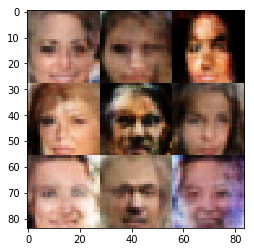

Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 2.7211
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.8766


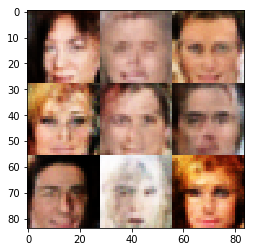

Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.5152
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.3429
Epoch 1/1... Discriminator Loss: 0.6818... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 2.9942


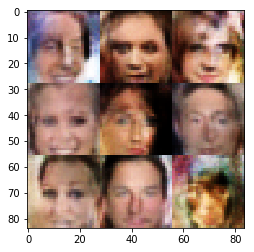

Epoch 1/1... Discriminator Loss: 1.9633... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.4705
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 3.2714
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.6817


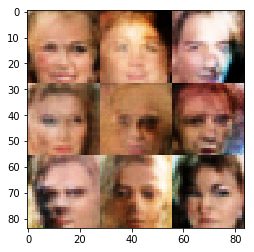

Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.4759
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.6460
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6003


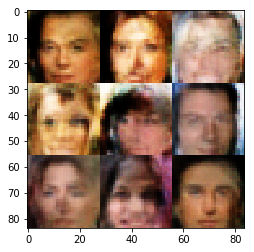

Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 3.2278
Epoch 1/1... Discriminator Loss: 1.6642... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5199


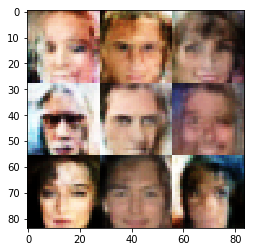

Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.9769


In [14]:
batch_size = 64
z_dim = 256
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.